### Import file from current directory

In [1]:
import os

In [2]:
cwd = os.getcwd()
file = 'file://{}/flight_data.csv'.format(cwd)

### Start a spark session

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
df = spark.read.csv(file, header=True, inferSchema=True)

In [5]:
df.show()

+----------+--------------+--------------+----+-----------------+------+
|Data_Venda|Canal_de_Venda|Local_de_Venda| PAX|Monetario_Vendido|   RPK|
+----------+--------------+--------------+----+-----------------+------+
| 11/1/2016|     Telegrafo|     Mindscape|  30|         2,188.11|  3476|
| 11/1/2016|     TeleVenda|         Arena|  52|         3,302.38|  8197|
| 11/1/2016|     TeleVenda|     Mindscape|  19|         1,041.54|  2425|
| 11/1/2016| Porta a Porta|     Mindscape| 496|        15,566.34| 53278|
| 11/1/2016|     TeleVenda|          Vast|  46|         2,721.43|  2039|
| 11/1/2016|     TeleVenda|         Arena| 485|        19,002.65| 66096|
| 11/1/2016|     TeleVenda|          Vast| 701|        11,588.27| 30866|
| 11/1/2016|     Telegrafo|         Arena|  39|         3,538.39|  5471|
| 11/1/2016|     TeleVenda|      Ellipsis|  44|         2,277.59|  2788|
| 11/1/2016| Porta a Porta|          Vast| 910|        14,451.80| 40112|
| 11/1/2016|     Telegrafo|      Ellipsis|  18|    

In [6]:
df.describe()

DataFrame[summary: string, Data_Venda: string, Canal_de_Venda: string, Local_de_Venda: string, PAX: string, Monetario_Vendido: string, RPK: string]

### Clean some data
##### As we can see, some important info are on a invalid format, such as Data_Venda.We need it to be a type of date. We also need to transform 'Monetario_Vendido' to float

In [7]:
from pyspark.sql.functions import to_date, unix_timestamp, from_unixtime, regexp_replace


In [8]:
df = df.withColumn(colName='Data_Venda', col=from_unixtime(unix_timestamp(df.Data_Venda, 'MM/dd/yyy')))

In [9]:
df = df.withColumn('Monetario_Vendido', regexp_replace('Monetario_Vendido', ',', ''))
df = df.withColumn('Monetario_Vendido', df['Monetario_Vendido'].cast("float"))


In [10]:
df.printSchema()

root
 |-- Data_Venda: string (nullable = true)
 |-- Canal_de_Venda: string (nullable = true)
 |-- Local_de_Venda: string (nullable = true)
 |-- PAX: integer (nullable = true)
 |-- Monetario_Vendido: float (nullable = true)
 |-- RPK: integer (nullable = true)



In [11]:
df.show()

+-------------------+--------------+--------------+----+-----------------+------+
|         Data_Venda|Canal_de_Venda|Local_de_Venda| PAX|Monetario_Vendido|   RPK|
+-------------------+--------------+--------------+----+-----------------+------+
|2016-11-01 00:00:00|     Telegrafo|     Mindscape|  30|          2188.11|  3476|
|2016-11-01 00:00:00|     TeleVenda|         Arena|  52|          3302.38|  8197|
|2016-11-01 00:00:00|     TeleVenda|     Mindscape|  19|          1041.54|  2425|
|2016-11-01 00:00:00| Porta a Porta|     Mindscape| 496|         15566.34| 53278|
|2016-11-01 00:00:00|     TeleVenda|          Vast|  46|          2721.43|  2039|
|2016-11-01 00:00:00|     TeleVenda|         Arena| 485|         19002.65| 66096|
|2016-11-01 00:00:00|     TeleVenda|          Vast| 701|         11588.27| 30866|
|2016-11-01 00:00:00|     Telegrafo|         Arena|  39|          3538.39|  5471|
|2016-11-01 00:00:00|     TeleVenda|      Ellipsis|  44|          2277.59|  2788|
|2016-11-01 00:0

# 1

#### To answer the first question, which is a ranking of PAX values for day of the week, we have to manipulate our dataframe by the days of the week.

In [12]:
from pyspark.sql.functions import dayofweek, date_format
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
withDayOfWeek = df.withColumn('DayOfWeek', date_format('Data_Venda', 'EEEE'))


In [14]:
paxByDayOfWeek = withDayOfWeek.select(withDayOfWeek.columns).groupBy(['DayOfWeek']).sum('PAX')

In [15]:
paxByDayOfWeek.show()

+---------+--------+
|DayOfWeek|sum(PAX)|
+---------+--------+
|Wednesday|  293025|
|  Tuesday|  219802|
|   Friday|  255625|
| Thursday|  258488|
| Saturday|  253467|
|   Monday|  236316|
|   Sunday|  241620|
+---------+--------+



#### Now, that we have grouped it all together, we just need to order it and we will have a ranking

In [16]:
paxByDayOfWeek.orderBy('sum(PAX)', ascending=False).show()

+---------+--------+
|DayOfWeek|sum(PAX)|
+---------+--------+
|Wednesday|  293025|
| Thursday|  258488|
|   Friday|  255625|
| Saturday|  253467|
|   Sunday|  241620|
|   Monday|  236316|
|  Tuesday|  219802|
+---------+--------+



# 2

#### The second question asks for the correlation between Saturdays and Sunday for the total number of RPK

In [44]:
from pyspark.sql.functions import sum, weekofyear

##### We need to aggregate weekdays and weekend info into columns 

In [45]:
WeekOfYear = df.withColumn('WeekOfYear', weekofyear('Data_Venda'))
dayOfWeek = WeekOfYear.withColumn('DayOfWeek', date_format('Data_Venda', 'EEEE'))

In [46]:
pivotted = dayOfWeek.groupBy(dayOfWeek['WeekOfYear']).pivot('DayOfWeek').sum('RPK')
pivotted = pivotted.fillna(0)
pivotted.show()

+----------+-------+-------+--------+-------+--------+-------+---------+
|WeekOfYear| Friday| Monday|Saturday| Sunday|Thursday|Tuesday|Wednesday|
+----------+-------+-------+--------+-------+--------+-------+---------+
|        44| 968225|      0| 1069765|1151471| 1051716| 367479|   837263|
|        12| 913536| 853830| 1132903|1074563| 1210062| 884447|  1266718|
|        47| 973077| 672603|  977747| 982092|  996507| 618017|  1011891|
|         1|1164142| 996003| 1268820|1258248| 1281244| 938424|  1291757|
|        52| 930336| 756871|  991491|1151843|  622785| 588396|   635117|
|        13|1113547| 897943| 1089231|      0| 1122293| 794130|  1166537|
|         6|1085007|2437811|  989582| 628719|  991076|2267341|  1582783|
|         3|1071148| 561508|  976881|1067681| 1010266| 580471|  1126931|
|        48|1047006| 655612| 1012842|1021314| 1032888| 630365|  1039745|
|         5| 985864| 682811| 1095524|1180881|  971198| 658690|  1043005|
|         9|1171968| 783970| 1231246|1128220| 12148

In [47]:
weekdays = pivotted.withColumn('Weekdays', (pivotted['Monday'] + pivotted['Tuesday'] +pivotted['Wednesday'] +pivotted['Thursday'] + pivotted['Friday']))


In [51]:
weekdaysAndWeekends = weekdays.withColumn('Weekends', (pivotted['Saturday'] + pivotted['Sunday']))
weekdaysAndWeekends = weekdaysAndWeekends.drop('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
weekdaysAndWeekends.show()


+----------+--------+--------+
|WeekOfYear|Weekdays|Weekends|
+----------+--------+--------+
|        44| 3224683| 2221236|
|        12| 5128593| 2207466|
|        47| 4272095| 1959839|
|         1| 5671570| 2527068|
|        52| 3533505| 2143334|
|        13| 5094450| 1089231|
|         6| 8364018| 1618301|
|         3| 4350324| 2044562|
|        48| 4405616| 2034156|
|         5| 4341568| 2276405|
|         9| 4744355| 2359466|
|         4| 5142307| 1966998|
|         8| 5758319| 1976702|
|        49| 4599494| 2073030|
|         7| 4279042| 3135394|
|        51| 3939254| 1774338|
|        10| 5472943| 1994462|
|        50| 6884861| 1686985|
|        45| 5416903| 2519910|
|        11| 5259059| 2326079|
+----------+--------+--------+
only showing top 20 rows



In [52]:
corr_mat= weekdaysAndWeekends.corr('Weekdays', 'Weekends', method="pearson")


In [53]:
corr_mat

-0.36205369993300873

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


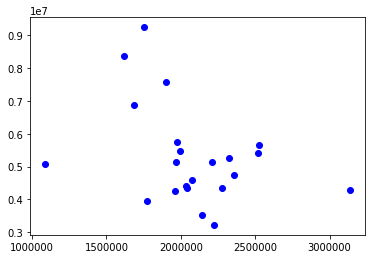

In [54]:
x = weekdaysAndWeekends.toPandas()
plt.plot( x['Weekends'], x['Weekdays'], 'bo')


# 3

#### Next, we are asked what is the mean and the median by Channel for month.


In [ ]:
from pyspark.sql.functions import month


In [ ]:
withMonth = df.withColumn('Month', month('Data_Venda'))

In [ ]:
grouppedByMonthAndChannel = withMonth.select(withMonth.columns).groupBy(['Canal_de_Venda', 'Month'])

#### The mean is:

In [ ]:
meanGrouppedByMonthAndChannel = grouppedByMonthAndChannel.mean('Monetario_Vendido')

In [ ]:
meanGrouppedByMonthAndChannel.select(meanGrouppedByMonthAndChannel.columns).orderBy(['Canal_de_Venda', 'Month'], ascending=True).show()

#### And the median is:

In [ ]:
from pyspark.sql.functions import expr


In [ ]:
 medianGrouppedByMonthAndChannel = grouppedByMonthAndChannel.agg(expr('percentile(Monetario_Vendido, array(0.5))')[0].alias('Median'))


In [ ]:
medianGrouppedByMonthAndChannel.select(medianGrouppedByMonthAndChannel.columns).orderBy(['Canal_de_Venda', 'Month'], ascending=True).show()

# 5

#### Supondo que você precisa gerar um estudo para a área responsável, com base em qualquer modelo ou premissa, qual ‘Local de Venda’ você considera mais crítico. Por quê?


In [55]:
locals = df.select(df['Local_de_Venda']).distinct().collect()
locals

[Row(Local_de_Venda='Ellipsis'),
 Row(Local_de_Venda='Mindscape'),
 Row(Local_de_Venda='Arena'),
 Row(Local_de_Venda='Vast')]

In [69]:
localsDict = {}
for local in locals:
    series = df.select(['Data_Venda', 'PAX']).filter(df['Local_de_Venda'] == local[0]).groupBy('Data_Venda').sum()
    series =  series.withColumnRenamed(existing='sum(PAX)', new='PAX')
    localsDict[local[0]] = series.toPandas()

(2000, 8000)

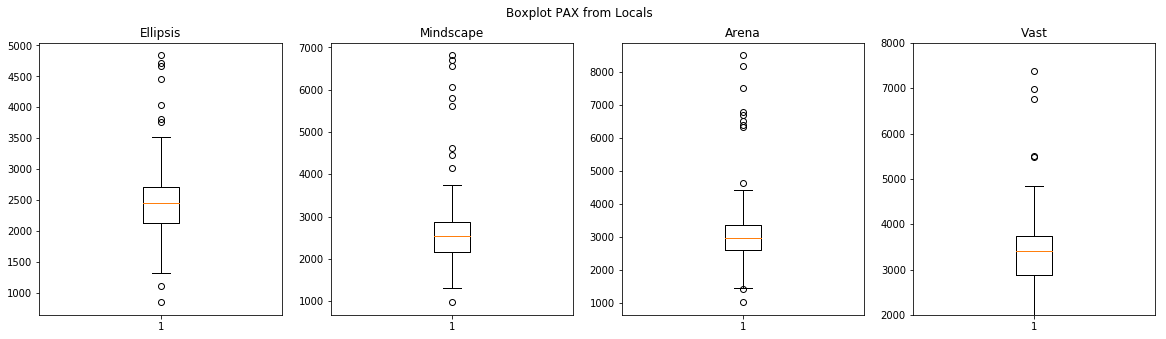

In [73]:

fig, (axs1, axs2, axs3, axs4) = plt.subplots(1,4, figsize=(20,5))
fig.suptitle('Boxplot PAX from Locals')
axs1.boxplot(localsDict['Ellipsis']['PAX'])
axs1.set_title("Ellipsis")
axs2.boxplot(localsDict['Mindscape']['PAX'])
axs2.set_title("Mindscape")
axs3.boxplot(localsDict['Arena']['PAX'])
axs3.set_title("Arena")
axs4.boxplot(localsDict['Vast']['PAX'])
axs4.set_title("Vast")
plt.ylim(2000, 8000)


